# Two-species hybrid diffusion–reaction: A ⇌ B (HybridModel user API)

This notebook shows how to set up and run a simple two-species hybrid model with diffusion and reversible switching:

- **A → B** with rate **alpha**
- **B → A** with rate **beta**

We use the **HybridModel** user API so you don't have to touch `HybridReactionSystem` or propensity lambdas directly.


In [1]:
import numpy as np

from srcm_engine import HybridModel
from srcm_engine.results.io import save_npz, load_npz
from srcm_engine.animation_util import AnimationConfig, animate_results, plot_mass_time_series


## 1) Build the model

In [2]:
# --- parameters ---
L = 10.0
K = 40
pde_multiple = 8
boundary = "zero-flux"

D = 0.1          # diffusion coefficient (same for A and B)
alpha = 0.01
beta = 0.01

threshold = 4
conversion_rate = 1.0

# --- model ---
m = HybridModel(species=["A", "B"])

m.domain(L=L, K=K, pde_multiple=pde_multiple, boundary=boundary)
m.diffusion(A=D, B=D)
m.conversion(threshold=threshold, rate=conversion_rate)

# PDE reaction terms in the user-friendly signature: lambda A, B, r -> (dA, dB)
m.reaction_terms(
    lambda A, B, r: (
        r["beta"] * B - r["alpha"] * A,   # dA
        r["alpha"] * A - r["beta"] * B,   # dB
    )
)

# macroscopic reactions -> auto-decomposed hybrid reactions
m.add_reaction({"A": 1}, {"B": 1}, rate_name="alpha")
m.add_reaction({"B": 1}, {"A": 1}, rate_name="beta")

# build engine
m.build(rates={"alpha": alpha, "beta": beta})

# optional: print reaction decomposition
m.describe_reactions()


0.0
0.0

 Reaction system description

=== Macroscopic reactions ===
[1] A → B    (rate_name='alpha')    (rate=0.01)
    Decomposed hybrid reactions:
      - [1] alpha_D
           Reactants: {'D_A': 1}
           Products : {'D_B': 1}
           State Δ  : {'D_A': -1, 'D_B': 1}
           Info     : D_A → D_B
[2] B → A    (rate_name='beta')    (rate=0.01)
    Decomposed hybrid reactions:
      - [2] beta_D
           Reactants: {'D_B': 1}
           Products : {'D_A': 1}
           State Δ  : {'D_B': -1, 'D_A': 1}
           Info     : D_B → D_A


## 2) Initial conditions (user-provided NumPy arrays)

In [3]:
# You provide raw numpy arrays:
#   init_ssa shape: (n_species, K)        int
#   init_pde shape: (n_species, n_pde)    float

n_species = len(m.species)
n_pde = m.domain_obj.n_pde

init_ssa = np.zeros((n_species, K), dtype=int)
init_pde = np.zeros((n_species, n_pde), dtype=float)

# Half-split: A on left quarter, B on right quarter
initial_particle_mass = 10
init_ssa[0, : K // 4] = initial_particle_mass
init_ssa[1, 3 * K // 4 :] = initial_particle_mass

init_ssa.shape, init_pde.shape


((2, 40), (2, 320))

## 3) Run repeats and save

In [ ]:
total_time = 30.0
dt = 0.006
repeats = 100
seed = 1

res_mean = m.run_repeats(
    init_ssa,
    init_pde,
    time=total_time,
    dt=dt,
    repeats=repeats,
    seed=seed,
    parallel=True,
    n_jobs=-1,
    progress=True,
)

out_npz = "ab_switch_mean.npz"

meta = m.metadata()
meta.update({
    "model": "A<->B",          # optional override
    "total_time": total_time,
    "dt": dt,
    "repeats": repeats,
    "seed": seed,
})

save_npz(res_mean, out_npz, meta=meta)

print("Saved:", out_npz)


Running SRCM repeats in parallel on 8 core(s)


SRCM repeats:   0%|          | 0/99 [00:00<?, ?run/s]

Results saved to single file: ab_switch_mean.npz
Saved: ab_switch_mean.npz


## 4) Quick visualisation

/Users/charliecameron/CodingHub/PhD/Y2_code/srcm-engine/srcm_engine/animation_util/animate.py:405: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


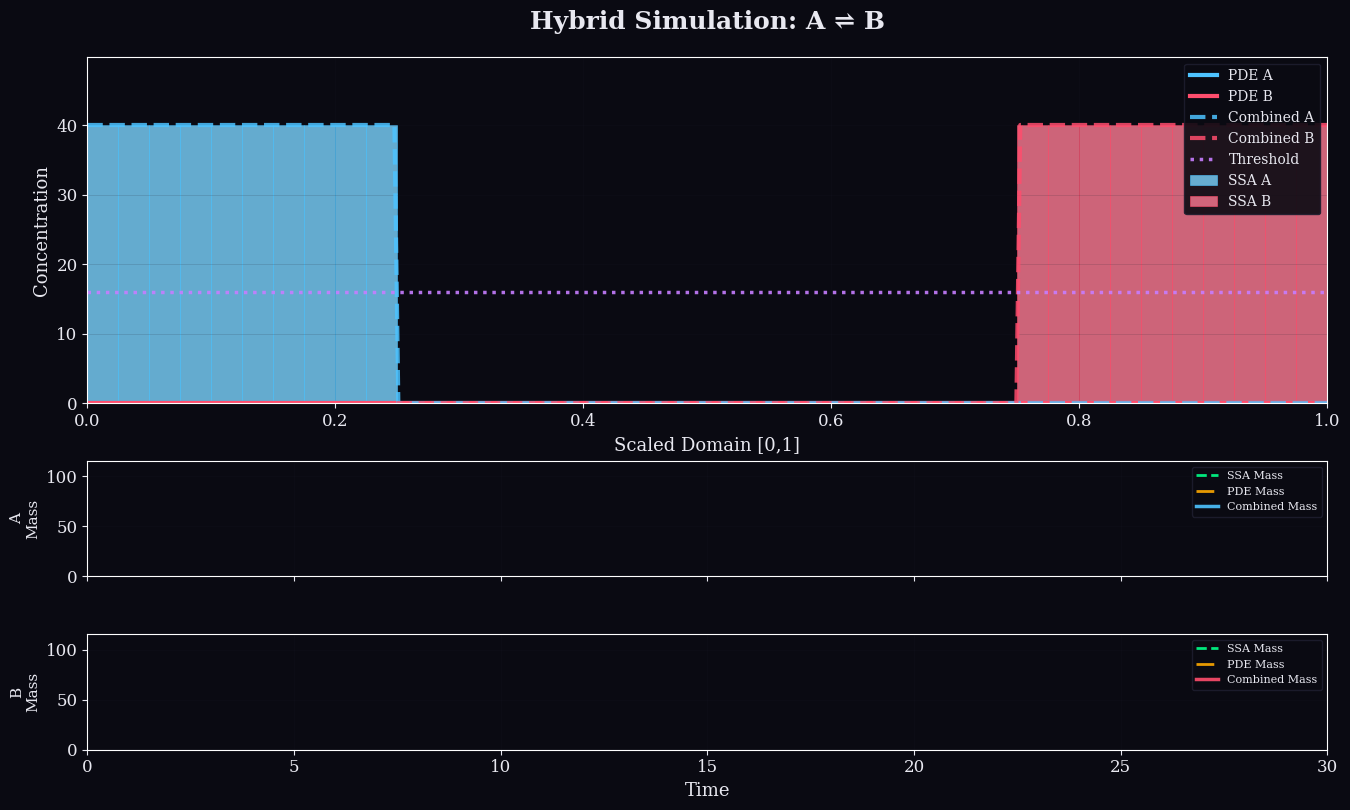

In [6]:
cfg = AnimationConfig(
    stride=20,
    interval_ms=25,
    threshold_particles=threshold,
    title="Hybrid Simulation: A ⇌ B",
    mass_plot_mode="per_species",
)
animate_results(res_mean, cfg=cfg)


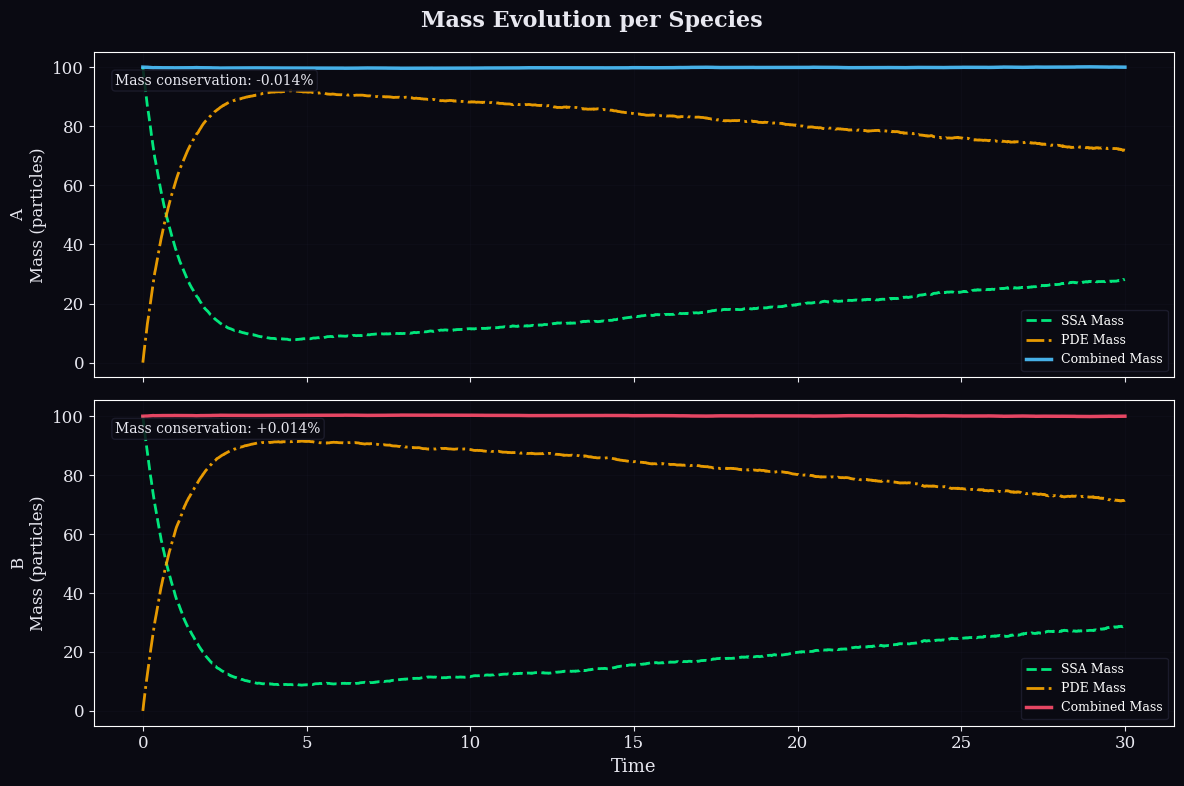

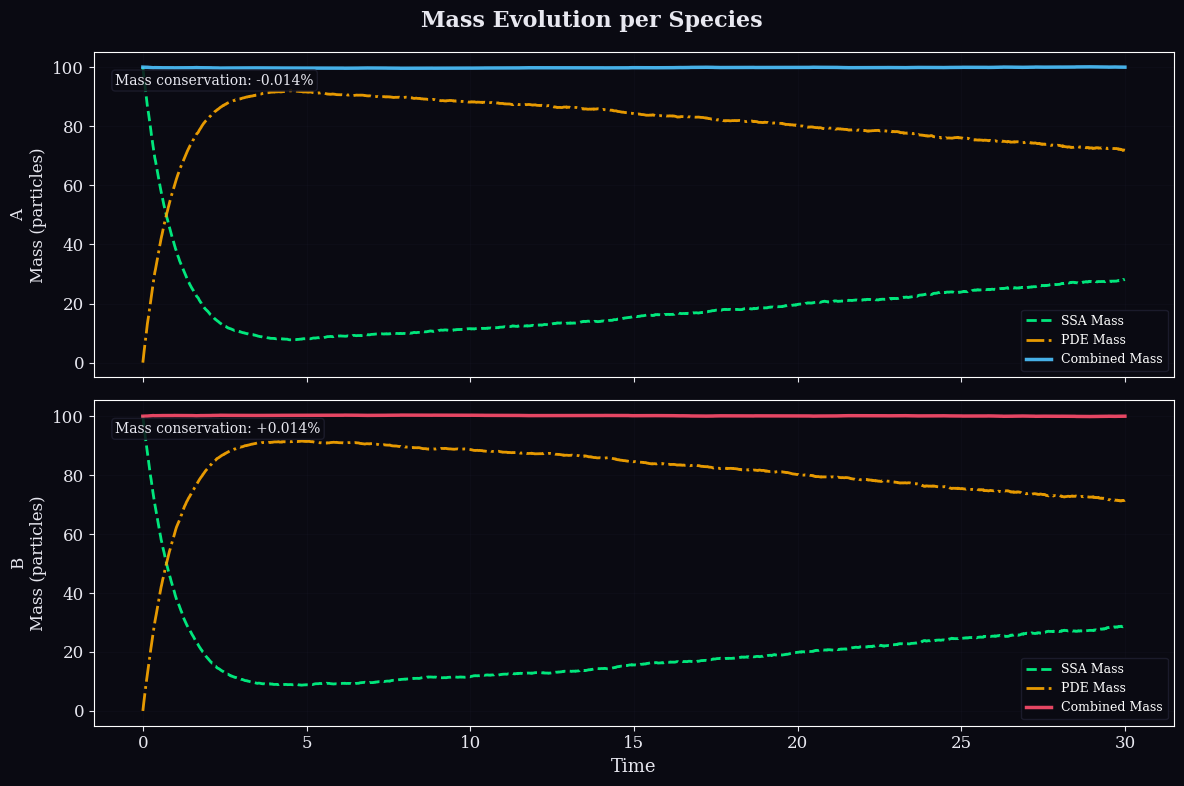

In [7]:
plot_mass_time_series(res_mean, plot_mode='per_species')

## 5) Reload later (optional)

In [8]:
loaded_res, loaded_meta = load_npz(out_npz)
print('Loaded meta keys:', sorted(list(loaded_meta.keys()))[:10], '...')


Loaded meta keys: ['D', 'K', 'L', 'alpha', 'beta', 'boundary', 'conversion_rate', 'dt', 'hybrid_labels', 'model'] ...
